# Recreating @idatadrew's implementation which can be found [here](https://public.tableau.com/views/NHL-ChangeinAverageAttendanceperGame/NHL-ChangeinAverageAttendanceperGame?:embed=y&:display_count=yes&publish=yes&:toolbar=no&:showVizHome=no).

## What is the % change in average attendance per game for NHL teams compared to the 2000-01 season?

In [1]:
import math
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt
pd.options.mode.chained_assignment = None #surpress is copy warning

In [2]:
df = pd.read_csv('./NHL Attendance.csv')
df.columns

Index(['SEASON', 'RANK', 'TEAM', 'HOME GAMES', ' HOME ATTENDANCE ',
       'ROAD GAMES', ' ROAD ATTENDANCE ', 'TOTAL GAMES', ' TOTAL ATTENDANCE '],
      dtype='object')

In [3]:
df = df.query('TEAM != "Vegas"')
print(df.groupby('TEAM')['SEASON'].count())

TEAM
Anaheim         17
Arizona         17
Boston          17
Buffalo         17
Calgary         17
Carolina        17
Chicago         17
Colorado        17
Columbus        17
Dallas          17
Detroit         17
Edmonton        17
Florida         17
Los Angeles     17
Minnesota       17
Montreal        17
NY Islanders    17
NY Rangers      17
Nashville       17
New Jersey      17
Ottawa          17
Philadelphia    17
Pittsburgh      17
San Jose        17
St. Louis       17
Tampa Bay       17
Toronto         17
Vancouver       17
Washington      17
Winnipeg        17
Name: SEASON, dtype: int64


In [4]:
def clean_numeric_column(df, column_name):
    series = df[column_name].str.strip()
    series = series.str.replace(',', '')
    series = pd.to_numeric(series)
    df[column_name] = series
    return df

def format_percent(season_one, season_two):
    percent = season_one / season_two;
    percent = percent - 1
    return round(percent * 100, 1)

def calculate_percent_change(current_attendance, team, df):
    row = df.query('SEASON == "2000-01" and TEAM == @team')
    starting_attendance = row.iloc[0]['AVERAGE ATTENDANCE PER GAME']

    return format_percent(current_attendance, starting_attendance)

In [5]:
data = df[['TEAM', 'SEASON', ' TOTAL ATTENDANCE ', 'TOTAL GAMES']]
data = clean_numeric_column(data, ' TOTAL ATTENDANCE ')


data['AVERAGE ATTENDANCE PER GAME'] = round(data[' TOTAL ATTENDANCE '] / data['TOTAL GAMES'], 0)
data['PREVIOUS AVERAGE ATTENDANCE PER GAME'] = data.groupby('TEAM')['AVERAGE ATTENDANCE PER GAME'].shift(-1)

data['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'] = data.apply(lambda row: 
    calculate_percent_change(
        row['AVERAGE ATTENDANCE PER GAME'],
        row['TEAM'],
        data
    ),
    axis = 1, #applies lambda to row                                                                 
)

data = data.query('SEASON != "2000-01"')

max_change = data['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'].max()
min_change = data['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'].min()
data['SEASON'] = data['SEASON'].str[2:] # remove leading 20
piviot_table = pd.pivot_table(data, values='PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME', index='TEAM',  columns='SEASON')


In [6]:
def sort_teams(df, key):
    result = df.groupby('TEAM')[key].sum().reset_index()
    result = df.sort_values(by=[key], ascending=False)
    result = result['TEAM'].unique().tolist()
    return result

team_order = sort_teams(data, 'PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME')
#team_order = sort_teams(data, ' TOTAL ATTENDANCE ')
piviot_table = piviot_table.reindex(team_order, axis=0)
print(piviot_table.query('TEAM == "Chicago"'))

SEASON   01-02  02-03  03-04  05-06  06-07  07-08  08-09  09-10  10-11  11-12  \
TEAM                                                                            
Chicago    2.6    0.9   -4.3   -5.0   -7.0    8.0   25.8   21.8   24.3   23.7   

SEASON   12-13  13-14  14-15  15-16  16-17  17-18  
TEAM                                               
Chicago   26.3   27.9   27.8   28.9   27.5   24.3  


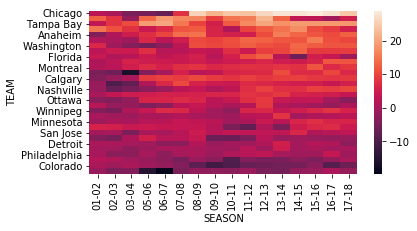

In [7]:
fig, ax = plt.subplots(figsize=(6,3)) # width, height
sns.heatmap(piviot_table, ax=ax)

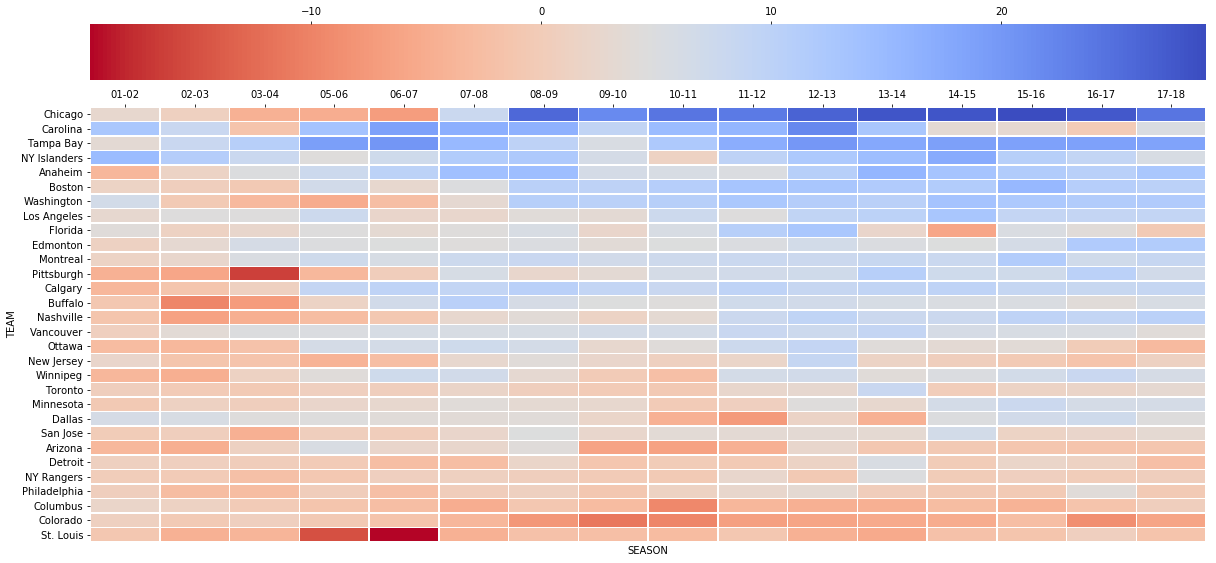

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, size_axis = plt.subplots(figsize=(20,10)) # width, height

#sns.set(font_scale=2)
#palette = sns.diverging_palette(20, 220, n=256)
cbar_kws = { 'use_gridspec': False, 'location': "top"}
ax = sns.heatmap(piviot_table, linewidth=0.5, cmap="coolwarm_r", cbar=True, cbar_kws=cbar_kws, vmax=max_change, vmin=min_change, ax=size_axis)
ax.xaxis.tick_top()

#axins = inset_axes(ax, width=1, height=0.25, loc='upper right', bbox_to_anchor=(0, 0.07, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
#im = ax.imshow([[0, 0], [1, 1]], cmap="coolwarm_r")
#fig.colorbar(im, cax=axins, ticks=[1, 2, 3], orientation="horizontal")


#ax.annotate('2004-05 lockout that caused the\n entire season to be lost', xy=(1, 1), xytext=(1, 32))
#plt.plot([3, 3], [-0.5, 30.5], 'k', linewidth=2)[0].set_clip_on(False)

#ax.annotate('2012-13 lockout saw a significant reduction in overall attendance, as 60% of\n regular-season games were cancelled; however, average attendance per\n game remained consistent', xy=(1, 1), xytext=(8, 33.5))
#plt.plot([10.5, 10.5], [30.25, 31.5], 'k', linewidth=2)[0].set_clip_on(False)

#plt.plot([-1.25, 0], [29.95, 29.95], 'k', linewidth=0.2)[0].set_clip_on(False)
#plt.plot([-1.25, 0], [0.05, 0.05], 'k', linewidth=0.2)[0].set_clip_on(False)


#ax.set_ylabel('')
#ax.set_xlabel("Season (2000's)")
#ax.xaxis.set_label_position('top')

Average attendance per game has steadily increased **compared to the 2000-01 season** for most teams. Chiago Blackhawks have seen the most <font color=blue>**positive % change**</font>, whereas Colorado Avalanche have seen the most <font color=red>**negative % change**</font>.

In [37]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def center_color_map(cmap, min_val, max_val, name):
    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val) # Edit #2
    midpoint = 1.0 - max_val/(max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint=False), np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5) # 0.5 = original midpoint.
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

def create_color(r, g, b):
    return [r/256, g/256, b/256]

def create_orange_blue_cmap(min_value, max_value):    
    N = 256
    cmap = LinearSegmentedColormap.from_list("", [
        create_color(227, 101, 33), create_color(246, 145, 53), create_color(251, 168, 74),
        create_color(218, 212, 200),
        create_color(141, 193, 223), create_color(114, 167, 208), create_color(43, 92, 138)
    ])
    
    return center_color_map(cmap, min_value, max_value, "")

-19.6 28.9


/opt/conda/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


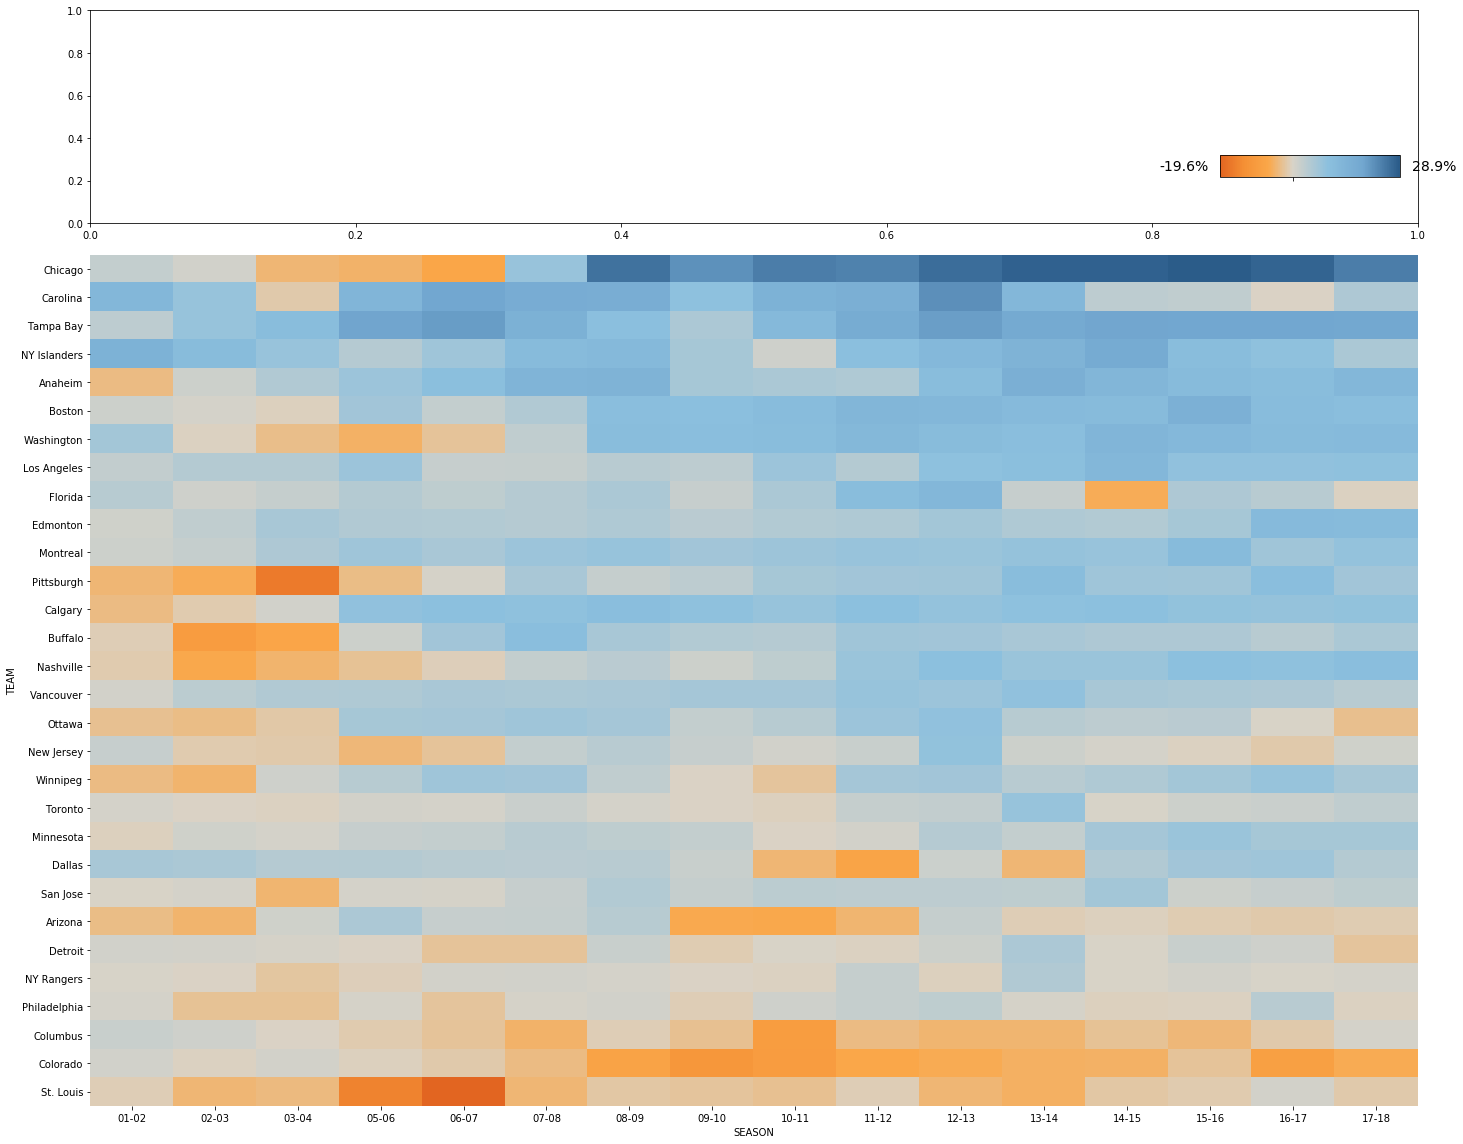

In [38]:
print(min_change, max_change)
cmap = create_orange_blue_cmap(min_change, max_change)

fig, (header_ax, heatmap_ax) = plt.subplots(nrows=2, figsize=(20,16), gridspec_kw={"height_ratios":[0.25, 1]})
sns.heatmap(piviot_table, ax=heatmap_ax, cbar=False, cmap=cmap)

#heatmap_ax.set_facecolor('xkcd:blue')
#header_ax.set_facecolor('xkcd:salmon')

colorbar_ax = fig.add_axes([0.85, .802, 0.125, 0.1]) # right, up
colorbar_im = colorbar_ax.imshow(piviot_table, cmap=cmap, aspect=0.125)
colorbar = fig.colorbar(colorbar_im, cax=colorbar_ax, orientation='horizontal', ticks=[0])
colorbar.ax.set_xticklabels([''])
colorbar_ax.annotate(str(min_change) + '%', xy=(1, 1), xytext=(-36, -5), fontsize=14)
colorbar_ax.annotate(str(max_change) + '%', xy=(1, 1), xytext=(32, -5), fontsize=14)


#colorbar_ax.set_facecolor('xkcd:blue')

#axins = inset_axes(header_ax, width=1, height=1, loc='upper right')
#im = header_ax.imshow([[0, 0], [1, 1]], cmap="coolwarm_r")
#fig.colorbar(im, cax=axins, orientation="horizontal")
plt.tight_layout()
plt.show()

TODO: colorbar
 . set colors with orange and blue

TODO: header
 . add text
 . color text
 . add image
 
TODO: heatmap
 . add annotations
 . remove y label
 . custom x label
 . shift ticks to top
 
TODO: other
 . surpess error
 . add blog post for floating colorbar

In [11]:
commit -> using custom color map

SyntaxError: invalid syntax (<ipython-input-11-05f369ca657a>, line 1)